In [1]:
import torch
import torch.nn as nn

# Discriminator Architecture

In [2]:
class Discriminator(nn.Module):
    def __init__(self, channels_img, features_d):
        super(Discriminator, self).__init__()
        self.disc = nn.Sequential(
            nn.Conv2d(
            channels_img, features_d, kernel_size = 4, stride = 2, padding = 1
            ),
            nn.LeakyReLU(0.2),
            #NOTE : Conv2d reduces the img dims, and padding prevents this by adding a few pixels
            # Conv block 1
            self._block(features_d, features_d*2, 4, 2, 1),
            # Conv block 2
            self._block(features_d*2, features_d*4, 4, 2, 1),
            # Conv block 3
            self._block(features_d*4, features_d*8, 4, 2, 1),
            nn.Conv2d(features_d*8, 1, kernel_size=4, stride=2, padding=0),
            nn.Sigmoid()
        )

    def _block(self, in_channels, out_channels, kernel_size, stride, padding):
        return nn.Sequential(
            nn.Conv2d(
                in_channels,
                out_channels,
                kernel_size,
                stride,
                padding,
                bias = False
            ),
            nn.BatchNorm2d(out_channels),
            nn.LeakyReLU(0.2),
        )

    def forward(self, x):
        return self.disc(x)

# Generator Architecture

In [3]:
class Generator(nn.Module):
    def __init__(self, z_dims, channels_img, features_g):
        super(Generator, self).__init__()
        # self.net is just a network with a combination of different layers
        self.gen = nn.Sequential(
            # Starts off with a 1D latent vector and converts into 4x4 spatial representation
            # The stride in a transpose convolution determines the spread and helps in upsampling instead of downsampling
            # we reduce the channels to achieve the final image
            self._block(z_dims, features_g*16, 4, 1, 0), # 4x4
            self._block(features_g*16, features_g*8, 4, 2, 1), # 8x8
            self._block(features_g*8, features_g*4, 4, 2, 1), # 16x16
            self._block(features_g*4, features_g*2, 4, 2, 1), # 32x32
            nn.ConvTranspose2d(
                features_g*2, channels_img, kernel_size = 4, stride = 2, padding =1
            ),
            nn.Tanh(),
        )

    def _block(self, in_channels, out_channels, kernel_Size, stride, padding):
        return nn.Sequential(
            nn.ConvTranspose2d(
                in_channels,
                out_channels,
                kernel_Size,
                stride,
                padding,
                bias = False
            ),
            nn.BatchNorm2d(out_channels),
            nn.ReLU()
        )

    def forward(self, x):
        return self.gen(x)

# Initializing the weights

In [4]:
# best practise to prevent mode collapse and weight explosion
def initialize_weights(model):
    # Iterates over the layers of an NN
    for m in model.modules():
        if isinstance(m, (nn.Conv2d, nn.ConvTranspose2d, nn.BatchNorm2d)):
            nn.init.normal_(m.weight.data, 0.0, 0.02)

In [5]:
def test():
    N, in_channels, H, W = 8, 3, 64, 64
    z_dim = 100
    x = torch.randn((N, in_channels, H, W))

    disc = Discriminator(in_channels, 8)
    initialize_weights(disc)
    assert disc(x).shape == (N, 1, 1, 1)

    gen = Generator(z_dim, in_channels, 8)
    z = torch.randn((N, z_dim, 1, 1))

    output = gen(z)
    print(f"Generator output shape: {output.shape}")
    assert output.shape == (N, in_channels, H, W)

    print('Success')

test()


Generator output shape: torch.Size([8, 3, 64, 64])
Success


# Hyperparameters

In [6]:
import torch.optim as optim
import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter

In [7]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [8]:
lr = 2e-4 
batch_size = 128
image_size = 64
channels_img = 1
z_dims = 100
num_epochs = 100
features_disc = 64
features_gen = 64

In [9]:
transforms = transforms.Compose([
    transforms.Resize(image_size),
    transforms.ToTensor(),
    transforms.Normalize(
        [0.5 for _ in range(channels_img)], [0.5 for _ in range(channels_img)] 
    )
])

In [10]:
dataset = datasets.MNIST(root = 'dataset/', transform = transforms, download = True)
loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

In [11]:
gen = Generator(z_dims, channels_img, features_gen).to(device)
disc = Discriminator(channels_img, features_disc).to(device)

In [12]:
initialize_weights(gen)
initialize_weights(disc)

In [13]:
opt_gen = optim.Adam(gen.parameters(), lr=lr, betas = (0.5, 0.999))
opt_disc = optim.Adam(disc.parameters(), lr=lr, betas = (0.5, 0.999))

In [14]:
loss = nn.BCELoss()

In [15]:
fixed_noise = torch.randn(32, z_dims, 1, 1).to(device)

In [16]:
writer_real = SummaryWriter(f'logs/real')
writer_fake = SummaryWriter(f'logs/fake')
step = 0

In [17]:
gen.train()
disc.train()

Discriminator(
  (disc): Sequential(
    (0): Conv2d(1, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.2)
    (2): Sequential(
      (0): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.2)
    )
    (3): Sequential(
      (0): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.2)
    )
    (4): Sequential(
      (0): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.2)
    )
    (5): Conv2d(512, 1, kernel_size=(4, 4), stride=(2, 2))
    (6): Sigmoid()
  )
)

# Model Training

In [19]:
for epoch in range(num_epochs):
    for batch, (real, _) in enumerate(loader):
        real = real.to(device)
        noise = torch.randn((batch_size, z_dims, 1, 1)).to(device)
        fake = gen(noise)
        
        ## Training the discriminator
        disc_real = disc(real).reshape(-1)
        loss_d_real = loss(disc_real, torch.ones_like(disc_real))
        disc_fake = disc(fake.detach()).reshape(-1)
        loss_d_fake = loss(disc_fake, torch.zeros_like(disc_fake))
        loss_disc = (loss_d_real + loss_d_fake) / 2

        disc.zero_grad()
        loss_disc.backward()
        opt_disc.step()

        ## Training the generator
        output = disc(fake).reshape(-1)
        loss_gen = loss(output, torch.ones_like(output))
        gen.zero_grad()
        loss_gen.backward()
        opt_gen.step()

        if batch % 100 == 0:
            print(f'Epoch [{epoch}/{num_epochs}] Batch [{batch}/{len(loader)}]')
            print(f'Loss D: {loss_disc:.4f}, Loss G: {loss_gen:.4f}')

            with torch.no_grad():
                fake = gen(fixed_noise)
                
                img_grid_fake = torchvision.utils.make_grid(real[:32], normalize = True)
                img_grid_real = torchvision.utils.make_grid(fake[:32], normalize = True)

                writer_fake.add_image(
                    'Mnist Fake Images', img_grid_fake, global_step=step
                )

                writer_real.add_image(
                    'Mnist Real Images', img_grid_real, global_step=step
                )

            step += 1

Epoch [0/100] Batch [0/469]
Loss D: 0.6291, Loss G: 1.3863
Epoch [0/100] Batch [100/469]
Loss D: 0.6075, Loss G: 0.9528
Epoch [0/100] Batch [200/469]
Loss D: 0.7066, Loss G: 0.7232
Epoch [0/100] Batch [300/469]
Loss D: 0.6399, Loss G: 0.8788
Epoch [0/100] Batch [400/469]
Loss D: 0.5155, Loss G: 1.5868
Epoch [1/100] Batch [0/469]
Loss D: 0.6508, Loss G: 0.2911
Epoch [1/100] Batch [100/469]
Loss D: 0.5465, Loss G: 0.7774
Epoch [1/100] Batch [200/469]
Loss D: 0.4295, Loss G: 1.7613
Epoch [1/100] Batch [300/469]
Loss D: 0.5934, Loss G: 4.3708
Epoch [1/100] Batch [400/469]
Loss D: 0.2488, Loss G: 1.7971
Epoch [2/100] Batch [0/469]
Loss D: 0.1783, Loss G: 1.9604
Epoch [2/100] Batch [100/469]
Loss D: 0.1724, Loss G: 3.3231
Epoch [2/100] Batch [200/469]
Loss D: 0.4560, Loss G: 4.8408
Epoch [2/100] Batch [300/469]
Loss D: 0.3906, Loss G: 1.2538
Epoch [2/100] Batch [400/469]
Loss D: 0.4233, Loss G: 3.3780
Epoch [3/100] Batch [0/469]
Loss D: 0.2639, Loss G: 3.5865
Epoch [3/100] Batch [100/469]
Lo

# Generating images

In [22]:
import matplotlib.pyplot as plt

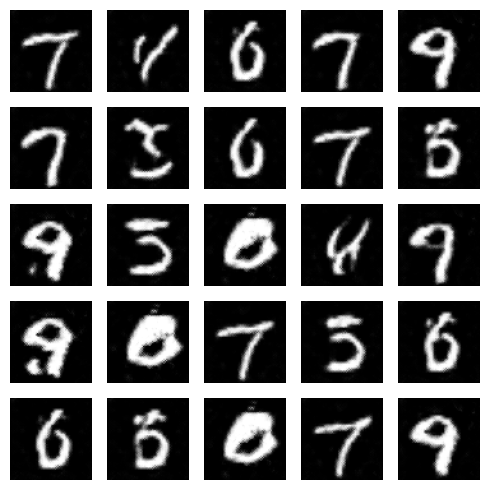

In [31]:
# First lets generate 10 noises
input_noise = torch.randn((10, z_dims, 1, 1)).to(device)

#setting the generator to evaluation mode
gen.eval()

with torch.no_grad():
    generated_images = gen(fixed_noise).detach().cpu()  # Generate fake images

# Normalize images to [0, 1] for display
generated_images = (generated_images + 1) / 2  

# Plot the 10 generated images in a 5x5 grid
fig, axes = plt.subplots(5, 5, figsize=(5, 5))

for i, ax in enumerate(axes.flatten()):
    ax.imshow(generated_images[i].permute(1, 2, 0).squeeze(), cmap='gray')
    ax.axis('off')

plt.tight_layout()
plt.show()

# Saving the model

In [32]:
torch.save(gen.state_dict(), "generator.pth")
torch.save(disc.state_dict(), "discriminator.pth")
print("Models have been saved!")

Models have been saved!
